In [1]:
%load_ext autoreload
%autoreload 3 --print

In [2]:
from kpsn.project.paths import Project, create_model
from kpsn.io import loaders
from kpsn.models import joint
from kpsn import config
from kpsn.models import instantiation, setup, pose, morph
from kpsn import fitting
from kpsn.models import util as model_util
from kpsn.io import alignment, features
from kpsn.fitting import em
from kpsn.io import utils as io_utils
from kpsn.fitting import methods
from kpsn.fitting import scans
from kpsn.io.armature import Armature
from kpsn.io.dataset import KeypointDataset, FeatureDataset
from kpsn import clouds
import os, sys, shutil
import numpy as np
import jax.numpy as jnp
from pprint import pprint
from kpsn.viz import model as viz_models
from kpsn.viz import util as viz_util
from kpsn.viz import styles
from kpsn import viz
plotter, colors = styles.init_nb("vscode_dark")

import glob
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import tqdm as tqdm
import jax.numpy.linalg as jla
import pandas as pd
import logging
logging.getLogger().setLevel(logging.INFO)

In [3]:
project_dir = '../projects/lrakp'
project = Project(project_dir)

# if os.path.exists(project_dir): shutil.rmtree(project_dir)
if not os.path.exists(project_dir):
    loaders.raw_npy.setup_project_config(
        project,
        filepaths = glob.glob(
            '../../../generative/datasets/lrakp_default-wild/*.npy'),
        ref_session = 'subj0',
        keypoint_names = [
            'shldr', 'back', 'hips', 't_base', 'head',
            'l_ear', 'r_ear', 'nose', 'lr_knee', 'lr_foot',
            'rr_knee', 'rr_foot', 'lf_foot', 'rf_foot'],
        keypoint_parents = [
            'back', 'hips', None, 'hips', 'shldr',
            'head', 'head', 'head', 'hips', 'lr_knee',
            'hips', 'rr_knee', 'shldr', 'shldr'])
    
    setup.setup_base_model_config(project)

In [4]:
cfg = config.load_project_config(project.main_config())
dataset = loaders.raw_npy.load(cfg["dataset"])

dataset, cfg = loaders.raw_npy.default_alignment.calibrate(
    project, dataset, cfg, origin="hips", anterior="head"
)

cfg = loaders.raw_npy.default_features.calibrate(project, dataset, cfg)
dataset, reduction_inverse = loaders.raw_npy.default_features._reduce(
    dataset, cfg["features"]
)
config.save_config(project.main_config(), cfg)

cfg = config.load_model_config(project.base_model_config())
cfg = pose.gmm.calibrate_base_model(project, dataset, cfg)
cfg = morph.lowrank_affine.calibrate_base_model(project, dataset, cfg)
cfg = em.calibrate_base_model(project, dataset, cfg)
config.save_model_config(project.base_model_config(), cfg)

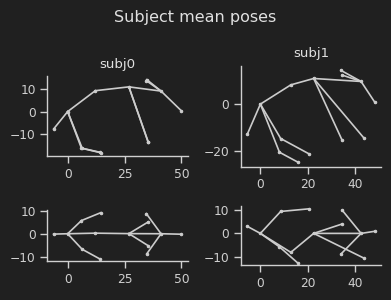

In [5]:
dataset = loaders.raw_npy.load(cfg["dataset"])
dataset_aligned, align_inverse = alignment.align(dataset, cfg["alignment"])
fig, ax = plt.subplots(
    2, dataset.n_sessions, figsize=(dataset.n_sessions * 2, 3)
)

for i, session in enumerate(dataset.sessions):
    viz_util.plot_mouse_views(
        ax[:, i],
        dataset.get_session(session).mean(axis=0),
        Armature.from_config(cfg["dataset"]),
        color=colors.neutral,
        specialkp=None,
    )
    ax[0, i].set_title(session)

fig.suptitle("Subject mean poses")
plotter.finalize(fig, None)

### Single model

In [181]:
model_dir, cfg = create_model(project, 'first_run', config_overrides = {
    'fit.learning_rate': 1,
    'fit.n_steps': 10,
    'pose.init.subsample': 0.5,
})
# fit_data = methods.fit(
#     project.model('first_run'),
#     log_every = 1,)

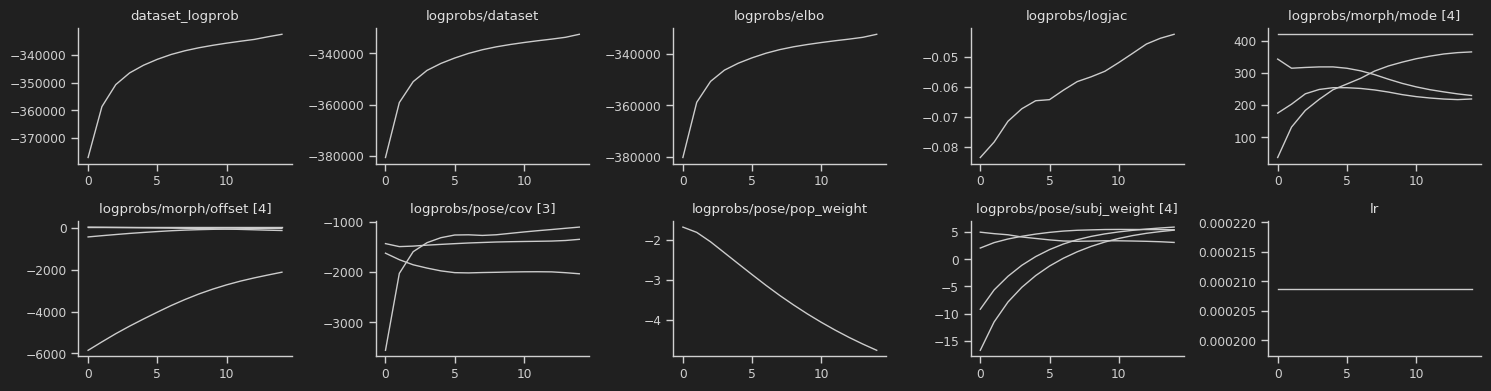

In [129]:
model_name = 'prior-scan_0'
ckpt = methods.load_fit(project.model(model_name))
fig = viz_models.report_plots(ckpt)
plotter.finalize(fig, None)

loading array /Users/kaifox/projects/mph/generative/datasets/lrakp_default-wild/subj0.npy
loading array /Users/kaifox/projects/mph/generative/datasets/lrakp_default-wild/subj1.npy


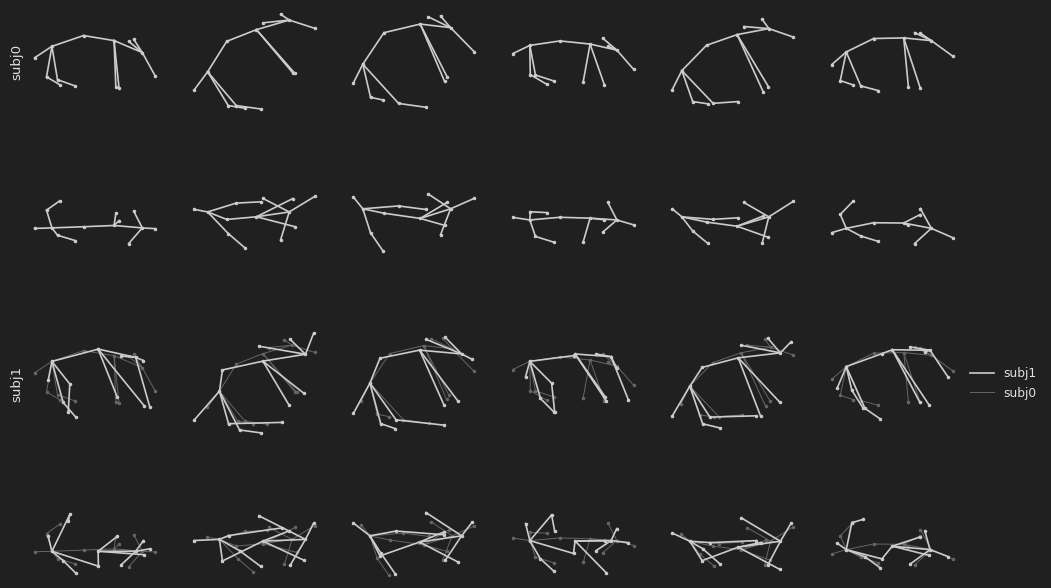

In [184]:
# Dataset
model_name = 'first_run'
dataset = loaders.raw_npy.load(cfg["dataset"])
dataset = methods.modify_dataset(project.model(model_name), dataset)
dataset_aligned, align_inverse = alignment.align(dataset, cfg["alignment"])
armature = Armature.from_config(cfg["dataset"])
gallery_ixs = viz.util.select_frame_gallery(
    dataset.get_session(dataset.ref_session),
    armature,
    return_ixs=True,
)

fig, ax = plt.subplots(
    2 * dataset.n_sessions,
    len(gallery_ixs),
    figsize=(len(gallery_ixs) * 2, dataset.n_sessions * 4),
)
for i, session in enumerate(dataset.sessions):
    for j, (pose_name, ix) in enumerate(gallery_ixs.items()):
        viz_util.plot_mouse_views(
            ax[2 * i : 2 * i + 2, j],
            dataset.get_session(session)[ix],
            armature,
            color=colors.neutral,
            label=(session if j == len(gallery_ixs) - 1 else None),
        )
        if session != dataset.ref_session:
            viz_util.plot_mouse_views(
                ax[2 * i : 2 * i + 2, j],
                dataset.get_session(dataset.ref_session)[ix],
                armature,
                color=colors.subtle,
                line_kw = dict(lw=0.7),
                label=dataset.ref_session,
                zorder = -3
            )   
    ax[2 * i, 0].set_ylabel(session)

for a in ax[2::2, -1]:
    viz.util.legend(a)

for a in ax.ravel():
    viz.util.axes_off(a)

In [ ]:
model = instantiation.get_model(cfg)
checkpoint = methods.load_fit(project.model("first_run"))

dataset_reduced, reduction_inverse = features.reduce_to_features(
    dataset_aligned, cfg["features"]
)
mapped_reduced = model_util.apply_bodies(
    model.morph,
    checkpoint["params"].morph,
    dataset_reduced,
    {s: dataset.sess_bodies[dataset.ref_session] for s in dataset.sessions},
)
mapped: KeypointDataset = features.inflate(mapped_reduced, cfg['features'], reduction_inverse)

In [ ]:
# Using frame correspondence between subj0 and subj1, map poses
armature = Armature.from_config(cfg["dataset"])
gallery_ixs = viz.util.select_frame_gallery(
    mapped.get_session("subj0"),
    armature,
    return_ixs=True,
)

fig, ax = plt.subplots(
    2 * mapped.n_sessions,
    len(gallery_ixs),
    figsize=(len(gallery_ixs) * 2, mapped.n_sessions * 4),
)
for i, session in enumerate(mapped.sessions):
    for j, (pose_name, ix) in enumerate(gallery_ixs.items()):
        viz_util.plot_mouse_views(
            ax[2 * i : 2 * i + 2, j],
            mapped.get_session(session)[ix],
            armature,
            color=colors.neutral,
            label=(session if j == len(gallery_ixs) - 1 else None),
        )
        if session != mapped.ref_session:
            viz_util.plot_mouse_views(
                ax[2 * i : 2 * i + 2, j],
                mapped.get_session(mapped.ref_session)[ix],
                armature,
                color=colors.subtle,
                line_kw = dict(lw=0.7),
                label=mapped.ref_session,
                zorder = -3
            )   
    ax[2 * i, 0].set_ylabel(session)

for a in ax[2::2, -1]:
    viz.util.legend(a)

for a in ax.ravel():
    viz.util.axes_off(a)

In [ ]:
fig, ax  = plt.subplots(1, dataset.n_sessions - 1, figsize = ((dataset.n_sessions - 1) * 2, 2))
ax = np.atleast_1d(ax)
for i, sess in enumerate([s for s in mapped.sessions if s != mapped.ref_session]):
    orig_errs = model_util.reconst_errs(
        dataset.get_session(sess), dataset.get_session(mapped.ref_session)
    )
    reconst_errs = model_util.reconst_errs(
        mapped.get_session(sess), mapped.get_session(mapped.ref_session)
    )
    strip_data = viz.util.stripplot(orig_errs, reconst_errs, stacked = True)
    ax[i].plot(*strip_data, '-', color = colors.subtle, lw = 0.5)
    ax[i].plot(*strip_data, 'o', color = colors.neutral, ms = 3)
    ax[i].set_title(sess)
    ax[i].set_xticks([0, 1])
    ax[0].set_xticklabels([f"", f""])
ax[0].set_xticklabels([f"Orig.", f"Reconst."])
ax[0].set_ylabel(f"Keypoint dist. to {dataset.ref_session}")
plotter.finalize(fig, None)


### Prior scan

In [4]:
scan_cfg, model_cfg = scans.setup_scan_config(project, "prior-scan", {
    # 'morph.upd_var_ofs': [1e-1],
    'morph.upd_var_ofs': [1e-1, 1e0, 1e1],
    # 'morph.upd_var_modes': [1e-2],
    'morph.upd_var_modes': [1e-2, 1e-1, 1e2],
}, model_overrides={
    'fit.learning_rate': 8,
    'fit.n_steps': 50,
})

# scan_cfg, model_cfg = scans.setup_scan_config(project, "woven-scan", {
#     'morph.upd_var_ofs': [1e-1, 1e0, 1e1],
#     'morph.upd_var_modes': [1e-2, 1e-1, 1e2],
# }, model_overrides={
#     'fit.learning_rate': 8,
#     'fit.n_steps': 50,
# }, scan_config_overrides={
#     'split_type': 'interleaved'
# })

scans.run_scan(project, "prior-scan", log_every=1, force_restart=True)

INFO:root:Removing existing model ../projects/lrakp/models/prior-scan_0
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kaifox/bin/miniconda3/envs/kpsn-dev/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 1198 frames
INFO:root:Adjusting learning rate:8 -> 0.0016701461377870565
INFO:root:Loading LR schedule: const
INFO:root:Step 0 : loss = 390231.875
INFO:ro

Reloading 'kpsn.project.paths'.
Reloading 'kpsn.models.morph.lowrank_affine'.


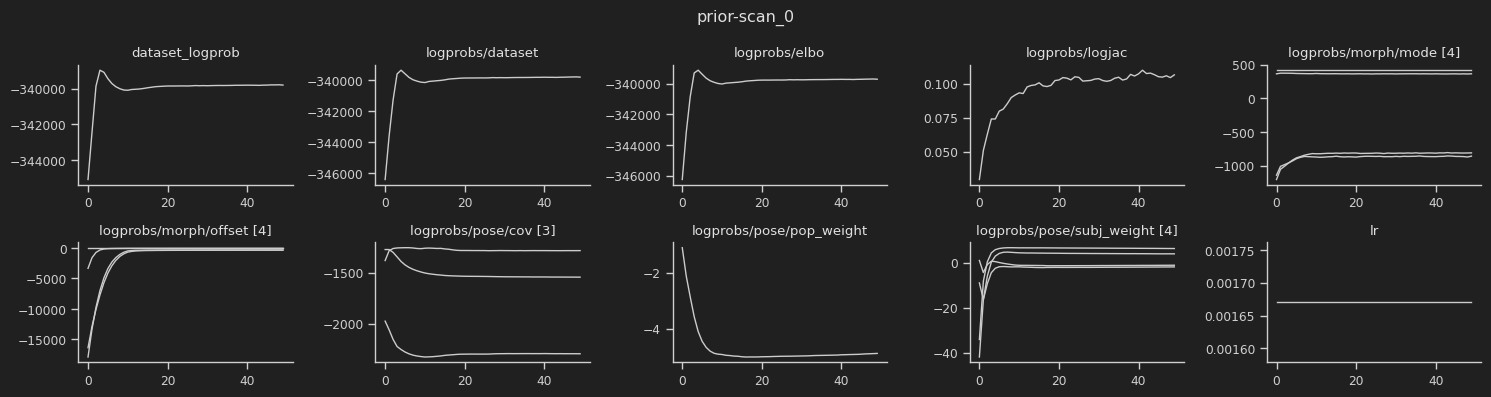

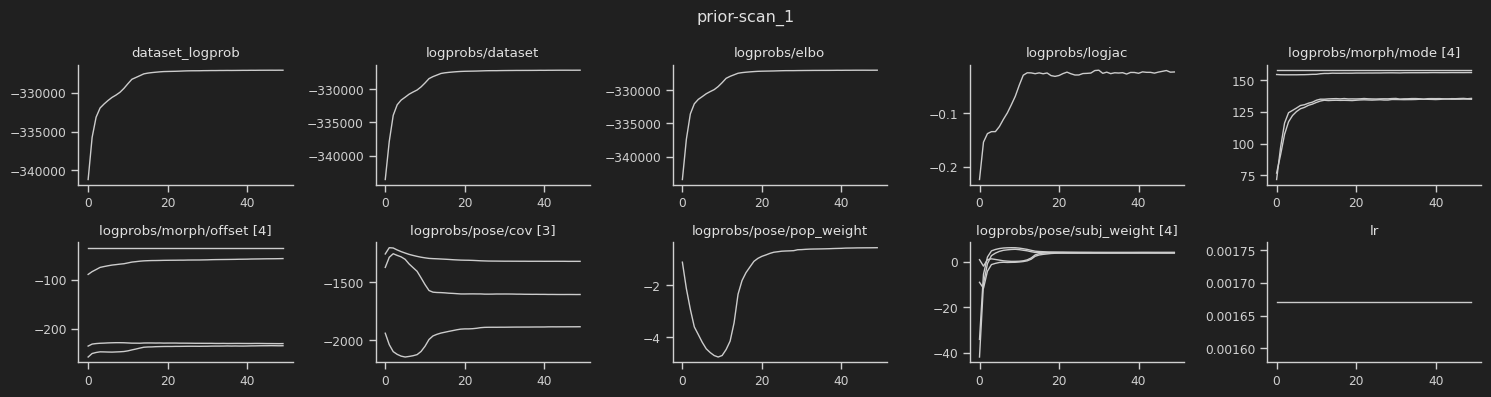

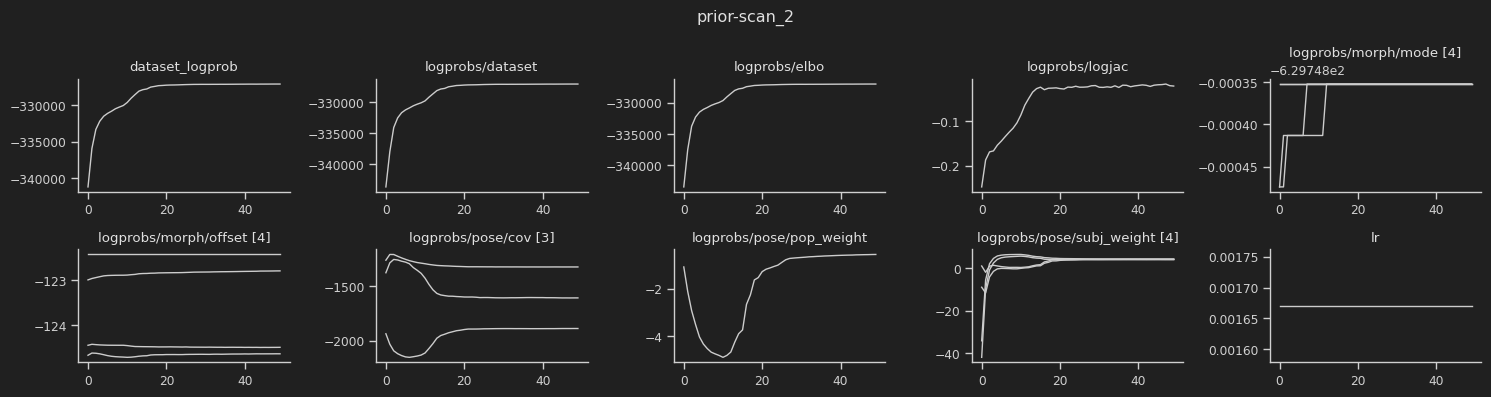

In [5]:
scan_cfg = config.load_config(project.scan("prior-scan") / "scan.yml")
for model_name in scan_cfg["models"]:
    ckpt = methods.load_fit(project.model(model_name))
    fig = viz_models.report_plots(ckpt)
    fig.suptitle(model_name)
    plotter.finalize(fig, None)

##### check initializations

In [5]:
import sys
cfg = config.load_model_config(project.base_model_config())
_dataset = loaders.load_dataset(cfg["dataset"])
_dataset, align_inverse = alignment.align(_dataset, cfg["alignment"])
_dataset = features.reduce_to_features(_dataset, cfg["features"])
sys.armature = Armature.from_config(cfg["dataset"])
sys._inflate = lambda x: features.inflate(x, cfg["features"])

In [17]:
model_dir = project.model("woven-scan_0")
cfg = config.load_model_config(model_dir / "model.yml")
_dataset = loaders.load_dataset(cfg["dataset"])
_dataset, align_inverse = alignment.align(_dataset, cfg["alignment"])
_dataset = features.reduce_to_features(_dataset, cfg["features"])
model = instantiation.get_model(cfg)


_dataset = methods.split_method.modify_dataset(_dataset, cfg["fit"])
from pprint import pprint
pprint(_dataset.sess_bodies)
pprint(_dataset._body_names)
pprint(_dataset._session_names)
print(_dataset.ref_session)
init_params = joint.initialize_joint_model(model, _dataset, cfg)

INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 600 frames


{'subj0.0': 'body-subj0.0',
 'subj0.1': 'body-subj0.1',
 'subj1.0': 'body-subj1.0',
 'subj1.1': 'body-subj1.1'}
bidict({0: 'body-subj0.0', 1: 'body-subj0.1', 2: 'body-subj1.0', 3: 'body-subj1.1'})
bidict({0: 'subj0.0', 1: 'subj0.1', 2: 'subj1.0', 3: 'subj1.1'})
subj0.0


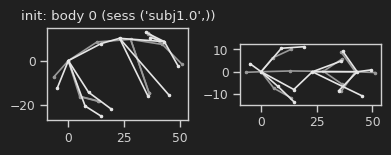

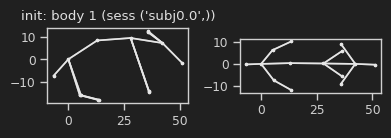

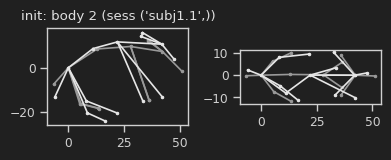

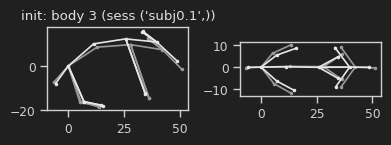

In [25]:
params = init_params.morph
offset_updates = params.offset_updates
armature = Armature.from_config(cfg["dataset"])
_inflate = lambda x: features.inflate(x, cfg["features"])
ref_ix = _dataset._body_names.inverse[_dataset.sess_bodies[_dataset.ref_session]]
for i in range(4):
    fig, ax = plt.subplots(1, 2, figsize=(4, 2))
    mean = offset_updates[i] + params.offset
    mean0 = offset_updates[ref_ix] + params.offset
    viz_util.plot_mouse_views(
        ax, _inflate(mean0), armature, color=".6", zorder=-3
    )
    viz_util.plot_mouse_views(ax, _inflate(mean), armature, color=".9")
    ax[0].set_title(f"init: body {i} (sess {_dataset._bodies_inv[_dataset._body_names[i]]})")
    fig.tight_layout()
    plt.show()

Split dataset means


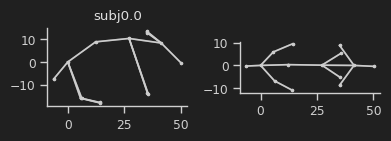

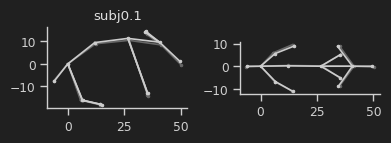

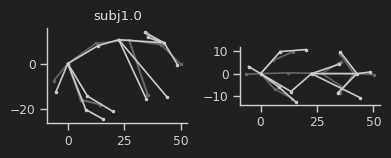

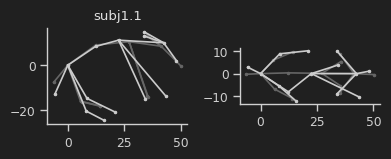

In [15]:
print("Split dataset means")
armature = Armature.from_config(cfg["dataset"])
_inflate = lambda x: features.inflate(x, cfg["features"])

for i in range(4):
    fig, ax = plt.subplots(1, 2, figsize = (4, 2))
    mean = _dataset.get_session(i).mean(axis = 0)
    mean0 = _dataset.get_session(_dataset.ref_session).mean(axis = 0)
    viz_util.plot_mouse_views(
        ax,
        _inflate(mean0),
        armature,
        color=colors.subtle,
        zorder = -3
    )
    viz_util.plot_mouse_views(
        ax,
        _inflate(mean),
        armature,
        color=colors.neutral,
    )
    ax[0].set_title(_dataset._session_names[i])
    plotter.finalize(fig, None)

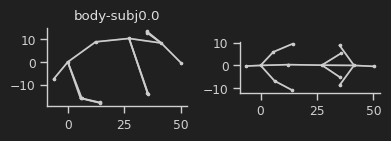

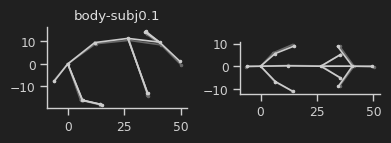

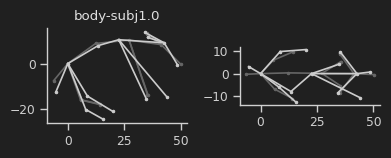

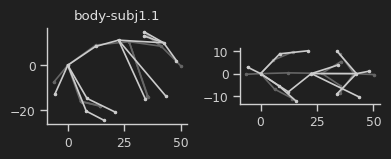

In [16]:
armature = Armature.from_config(cfg["dataset"])
_inflate = lambda x: features.inflate(x, cfg["features"])
ref_ix = _dataset._body_names.inverse[_dataset.sess_bodies[_dataset.ref_session]]
for i in range(4):
    fig, ax = plt.subplots(1, 2, figsize = (4, 2))
    ctr = init_params.morph.offset + init_params.morph.offset_updates[i]
    ctr0 = init_params.morph.offset + init_params.morph.offset_updates[ref_ix]
    viz_util.plot_mouse_views(
        ax,
        _inflate(ctr0),
        armature,
        color=colors.subtle,
        zorder = -3
    )
    viz_util.plot_mouse_views(
        ax,
        _inflate(ctr),
        armature,
        color=colors.neutral,
    )
    ax[0].set_title(_dataset._body_names[i])
    plotter.finalize(fig, None)

##### normal scan analysis

In [17]:
# for each body in the dataset, calculate the reconstruction error
# after morphing to a within-body reference session of the model that
# did not know these bodies should be identical

errs = defaultdict(dict)
scan_cfg = config.load_config(project.scan("woven-scan") / "scan.yml")
dataset = None
for model_name in scan_cfg["models"]:
    cfg = config.load_model_config(project.model_config(model_name))
    model = instantiation.get_model(cfg)
    checkpoint = methods.load_fit(project.model(model_name))

    # all models will have same dataset, even after modification by the fit function
    if dataset is None:
        # load split and non-split versions of the dataset
        dataset = loaders.raw_npy.load(cfg["dataset"])
        dataset_aligned, align_inverse = alignment.align(dataset, cfg["alignment"])
        dataset_reduced, reduction_inverse = features.reduce_to_features(
            dataset_aligned, cfg["features"]
        )
        dataset_train = methods.modify_dataset(
            project.model(model_name), dataset_reduced
        )
        _inflate = lambda x: features.inflate(x, cfg["features"], reduction_inverse)
        inflated_train =  _inflate(dataset_train)

        # map from original dataset bodies to sessions in the split dataset
        _body_inv = io_utils.split_body_inv(dataset, 
            cfg["fit"]["split_all"],
            cfg["fit"]["split_type"],
            cfg["fit"]["split_count"],)
        
    errs[model_name] = {}
    for b in _body_inv:
        nonref_sessions = _body_inv[b][1:]
        ref_body = dataset_train.sess_bodies[_body_inv[b][0]]
        subset = dataset_train.session_subset(nonref_sessions, bad_ref_ok=True)
        mapped_reduced = model_util.apply_bodies(
            model.morph,
            checkpoint["params"].morph,
            subset,
            {s: ref_body for s in nonref_sessions},
        )
        mapped = _inflate(mapped_reduced)

        errs[model_name][b] = {
            s: model_util.reconst_errs(
               inflated_train.get_session(s), mapped.get_session(s)
            )
            for s in nonref_sessions
        }

['woven-scan_0', 'woven-scan_1', 'woven-scan_2']


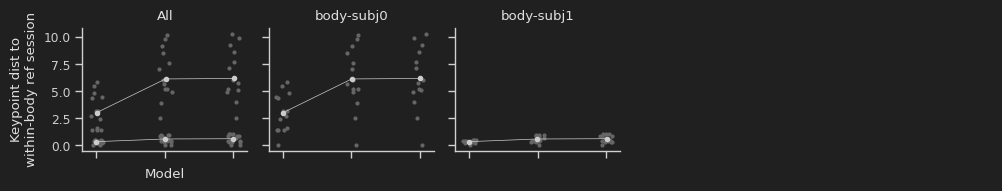

In [18]:
models = list(scan_cfg["models"].keys())
print(models)
fig, ax, ax_grid = viz.util.flat_grid(
    dataset.n_bodies + 1, n_col=5, ax_size=(2, 2), sharey = True, sharex = True
)
for _a, b in zip(ax[1:], dataset.bodies):
    for a in [_a, ax[0]]: 
        err_data = [jnp.array(list(errs[m][b].values())) for m in models]

        strip_data = viz.util.stripplot(
            *[arr.ravel() for arr in err_data],
            stacked=True,
        )
        a.plot(*strip_data, "o", color=colors.subtle, ms=2, zorder=-1)

        strip_data = viz.util.stripplot(
            *[arr.mean(axis=-1) for arr in err_data], stacked=True, jitter=0.01
        )
        a.plot(*strip_data, "o-", color=colors.neutral, ms=3, lw=0.5)
    _a.set_title(b)
    _a.set_xticks(range(len(models)))
    _a.set_xticklabels([""] * len(models))
ax[0].set_title("All")
ax_grid[-1, 0].set_xlabel("Model")
ax_grid[0, 0].set_ylabel("Keypoint dist to\nwithin-body ref session")
plotter.finalize(fig, None)

In [55]:
# for each body in the dataset, calculate the keypoint-wise error induced by mapping into canonical pose space
# using a reference morph (per-body) instead of the sessions's own morph from the split training

errs = defaultdict(dict)
scan_cfg = config.load_config(project.scan("prior-scan") / "scan.yml")
dataset = None
for model_name in scan_cfg["models"]:
    cfg = config.load_model_config(project.model_config(model_name))
    model = instantiation.get_model(cfg)
    checkpoint = methods.load_fit(project.model(model_name))

    # all models will have same dataset, even after modification by the fit function
    if dataset is None:
        # load split and non-split versions of the dataset
        dataset = loaders.raw_npy.load(cfg["dataset"])
        dataset_aligned, align_inverse = alignment.align(dataset, cfg["alignment"])
        dataset_reduced, reduction_inverse = features.reduce_to_features(
            dataset_aligned, cfg["features"]
        )
        dataset_train = methods.modify_dataset(
            project.model(model_name), dataset_reduced
        )
        _inflate = lambda x: features.inflate(x, cfg["features"], reduction_inverse)
        inflated_train =  _inflate(dataset_train)

        # map from original dataset bodies to sessions in the split dataset
        _body_inv = io_utils.split_body_inv(dataset, 
            cfg["fit"]["split_all"],
            cfg["fit"]["split_type"],
            cfg["fit"]["split_count"],)
        
    # select session/body for canonical pose space
    global_ref_body = dataset_train.sess_bodies[dataset_train.ref_session]
        
    errs[model_name] = {}
    for b in _body_inv:
        nonref_sessions = _body_inv[b][1:]
        ref_body = dataset_train.sess_bodies[_body_inv[b][0]]
        # nonref sessions mapped to canonical pose space
        subset = dataset_train.session_subset(nonref_sessions, bad_ref_ok=True)
        mapped_split_body = model_util.apply_bodies(
            model.morph,
            checkpoint["params"].morph,
            subset,
            {s: global_ref_body for s in nonref_sessions},
        )
        mapped_split_body = _inflate(mapped_split_body)
        # pretend all nonref sessions have body `ref_body`, mapped to canonical pose space
        with_ref_body = subset.with_sess_bodies({s: ref_body for s in nonref_sessions})
        mapped_ref_body = model_util.apply_bodies(
            model.morph,
            checkpoint["params"].morph,
            with_ref_body,
            {s: global_ref_body for s in nonref_sessions},
        )
        mapped_ref_body = _inflate(mapped_ref_body)
        
        errs[model_name][b] = {
            s: model_util.reconst_errs(
               mapped_ref_body.get_session(s), mapped_split_body.get_session(s)
            )
            for s in nonref_sessions
        }

['prior-scan_0', 'prior-scan_1', 'prior-scan_2']


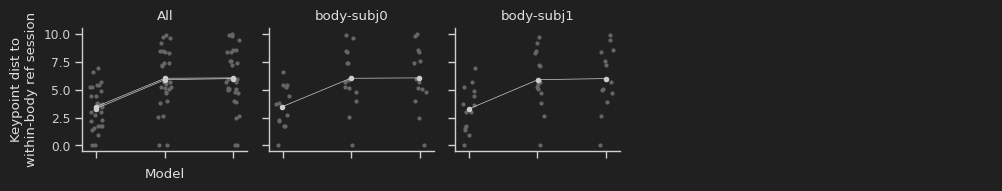

In [56]:
models = list(scan_cfg["models"].keys())
print(models)
fig, ax, ax_grid = viz.util.flat_grid(
    dataset.n_bodies + 1, n_col=5, ax_size=(2, 2), sharey = True, sharex = True
)
for _a, b in zip(ax[1:], dataset.bodies):
    for a in [_a, ax[0]]: 
        err_data = [jnp.array(list(errs[m][b].values())) for m in models]

        strip_data = viz.util.stripplot(
            *[arr.ravel() for arr in err_data],
            stacked=True,
        )
        a.plot(*strip_data, "o", color=colors.subtle, ms=2, zorder=-1)

        strip_data = viz.util.stripplot(
            *[arr.mean(axis=-1) for arr in err_data], stacked=True, jitter=0.01
        )
        a.plot(*strip_data, "o-", color=colors.neutral, ms=3, lw=0.5)
    _a.set_title(b)
    _a.set_xticks(range(len(models)))
    _a.set_xticklabels([""] * len(models))
ax[0].set_title("All")
ax_grid[-1, 0].set_xlabel("Model")
ax_grid[0, 0].set_ylabel("Keypoint dist to\nwithin-body ref session")
plotter.finalize(fig, None)

Reloading 'kpsn.viz.scans'.


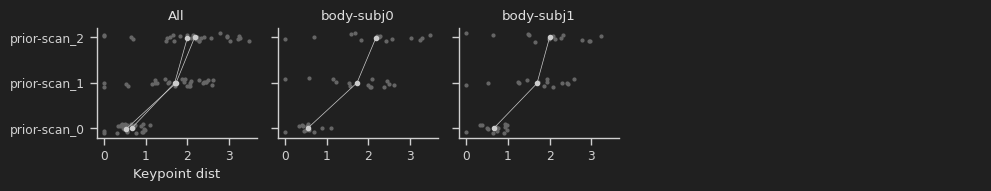

In [15]:
fig = viz.scans.withinbody_reconst_errs(project, "prior-scan")
plotter.finalize(fig, None)

In [24]:
# for each body in the original dataset, compute JS distances from each example
# of that body in the split dataset to an example of the reference session's body
# in the split dataset

jsds = defaultdict(dict)
scan_cfg = config.load_config(project.scan("prior-scan") / "scan.yml")
dataset = None
for model_name in scan_cfg["models"]:
    cfg = config.load_model_config(project.model_config(model_name))
    if dataset is None:
        # dataset in various shapes and sizes
        dataset = loaders.raw_npy.load(cfg["dataset"])
        dataset_aligned, align_inverse = alignment.align(
            dataset, cfg["alignment"]
        )
        dataset_reduced, reduction_inverse = features.reduce_to_features(
            dataset_aligned, cfg["features"]
        )
        dataset_train = methods.modify_dataset(
            project.model(model_name), dataset_reduced
        )
        ref_cloud = clouds.PointCloudDensity(k=15).fit(
            dataset_train.get_session(dataset_train.ref_session)
        )
        # map from original dataset bodies to sessions in the split dataset
        _body_inv = io_utils.split_body_inv(
            dataset,
            cfg["fit"]["split_all"],
            cfg["fit"]["split_type"],
            cfg["fit"]["split_count"],
        )

    model = instantiation.get_model(cfg)
    checkpoint = methods.load_fit(project.model(model_name))

    # transform all sessions to the global reference session's body
    for b in tqdm.tqdm(_body_inv, desc = model_name):

        ref_body = dataset_train.sess_bodies[dataset_train.ref_session]
        subset = dataset_train.session_subset(_body_inv[b], bad_ref_ok=True)
        mapped = model_util.apply_bodies(
            model.morph,
            checkpoint["params"].morph,
            subset,
            {s: ref_body for s in _body_inv[b]},
        )

        # compute JS distances
        jsds[model_name][b] = {
            s: clouds.ball_cloud_js(
                ref_cloud,
                clouds.PointCloudDensity(k=15).fit(mapped.get_session(s)),
            )
            for s in _body_inv[b]
        }

Reloading 'kpsn.clouds'.


prior-scan_2: 100%|██████████| 2/2 [00:00<00:00,  7.79it/s]


Reloading 'kpsn.viz.scans'.
['prior-scan_0', 'prior-scan_1', 'prior-scan_2']


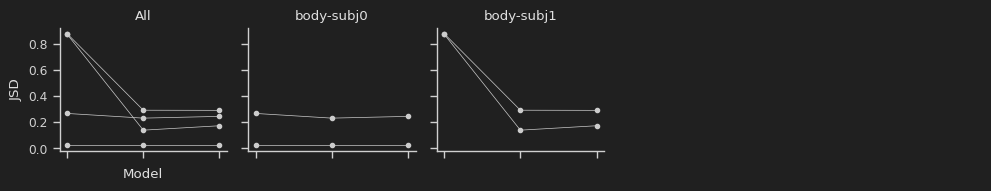

In [30]:
models = list(scan_cfg["models"].keys())
print(models)
fig, ax, ax_grid = viz.util.flat_grid(
    dataset.n_bodies + 1, n_col=5, ax_size=(2, 2), sharey = True, sharex = True
)
for _a, b in zip(ax[1:], dataset.bodies):
    for a in [_a, ax[0]]: 
        jsd_data = [jnp.array(list(jsds[m][b].values())) for m in models]
        a.plot(jsd_data, "o-", color=colors.neutral, ms=3, lw=0.5)
    _a.set_title(b)
    _a.set_xticks(range(len(models)))
    _a.set_xticklabels([""] * len(models))
ax[0].set_title("All")
ax[0].set_ylabel("JSD")
ax_grid[-1, 0].set_xlabel("Model")
plotter.finalize(fig, None)

Reloading 'kpsn.viz.scans'.


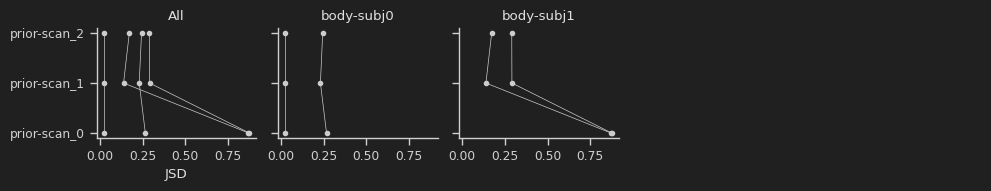

In [32]:
fig = viz.scans.jsds_to_reference(project, "prior-scan")
plotter.finalize(fig, None)

### Scan: specific plots for LRAKP

In [57]:
# map `compare` session on to `ref` session, where the two have exact
# frame correspondence
mappings = {"ref": ["subj0.0", "subj0.1"], "compare": ["subj1.0", "subj1.1"]}


scan_cfg = config.load_config(project.scan("prior-scan") / "scan.yml")
dataset = None
ref = defaultdict(list); mapped = defaultdict(list); compare = defaultdict(list)
for model_name in scan_cfg["models"]:
    cfg = config.load_model_config(project.model_config(model_name))
    armature = Armature.from_config(cfg["dataset"])
    model = instantiation.get_model(cfg)
    checkpoint = methods.load_fit(project.model(model_name))

    # all models will have same dataset, even after modification by the fit function
    if dataset is None:
        # load split and non-split versions of the dataset
        dataset = loaders.raw_npy.load(cfg["dataset"])
        dataset_aligned, align_inverse = alignment.align(
            dataset, cfg["alignment"]
        )
        dataset_reduced, reduction_inverse = features.reduce_to_features(
            dataset_aligned, cfg["features"]
        )
        dataset_train = methods.modify_dataset(
            project.model(model_name), dataset_reduced
        )
        _inflate = lambda x: features.inflate(
            x, cfg["features"], reduction_inverse
        )
        inflated_train = _inflate(dataset_train)

        # map from original dataset bodies to sessions in the split dataset
        _body_inv = io_utils.split_body_inv(
            dataset,
            cfg["fit"]["split_all"],
            cfg["fit"]["split_type"],
            cfg["fit"]["split_count"],
        )

        n_mappings = len(mappings["ref"])
        galleries = [
            jnp.stack(list(viz.util.select_frame_gallery(
                inflated_train.get_session(ref_sess), armature, return_ixs=True
            ).values()))
            for ref_sess in mappings["ref"]
        ]

    for i_map in range(n_mappings):
        ref_sess = mappings["ref"][i_map]
        compare_sess = mappings["compare"][i_map]
        pose_ixs = galleries[i_map]
        ref_body = dataset_train.sess_bodies[ref_sess]
        compare_body = dataset_train.sess_bodies[compare_sess]

        # map from compare_sess onto the body of ref_sess and grab pose_ixs
        mapped_reduced = model_util.apply_bodies(
            model.morph,
            checkpoint["params"].morph,
            dataset_train.session_subset([compare_sess], bad_ref_ok=True),
            {compare_sess: ref_body},
        ).get_session(compare_sess)[pose_ixs]
        mapped[model_name].append(_inflate(mapped_reduced))
        ref[model_name].append(inflated_train.get_session(ref_sess)[pose_ixs])
        compare[model_name].append(inflated_train.get_session(compare_sess)[pose_ixs])

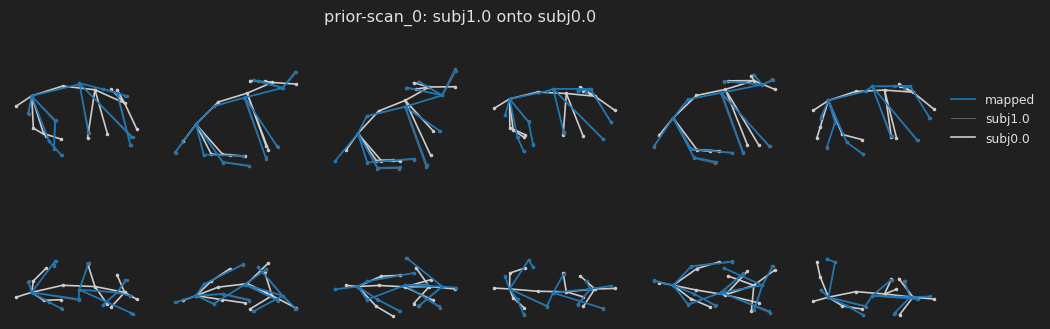

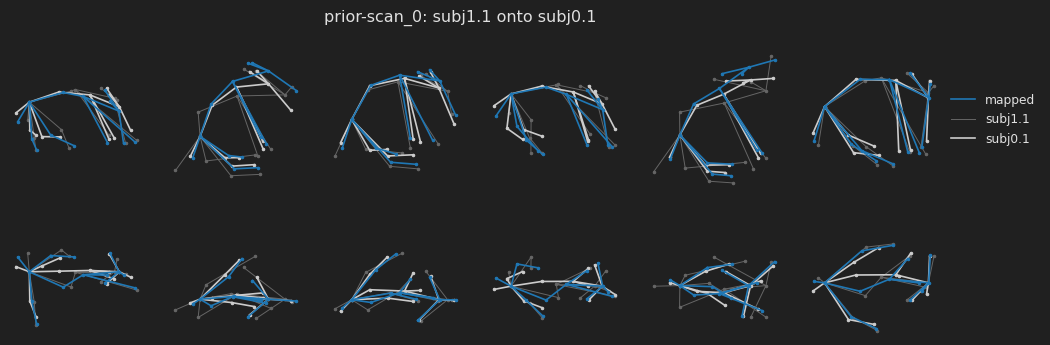

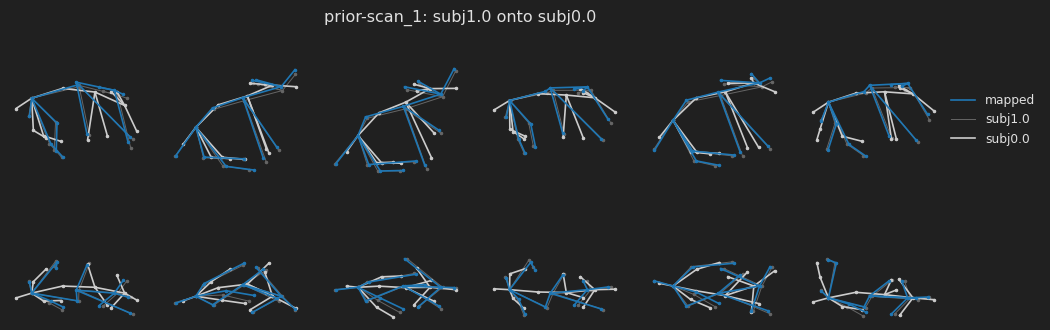

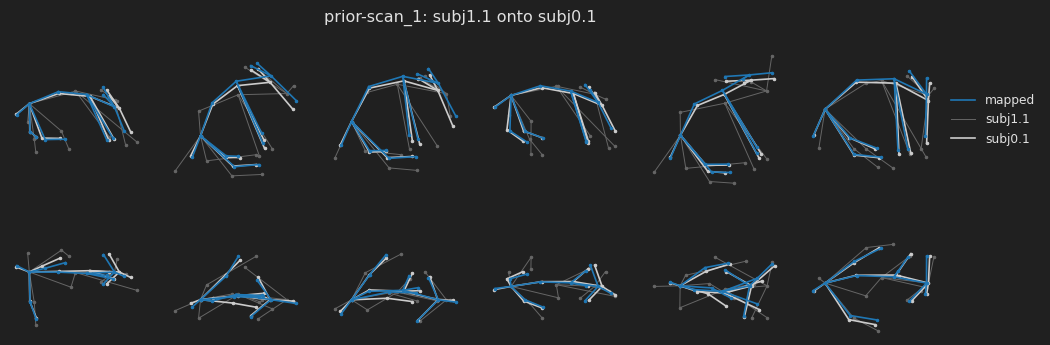

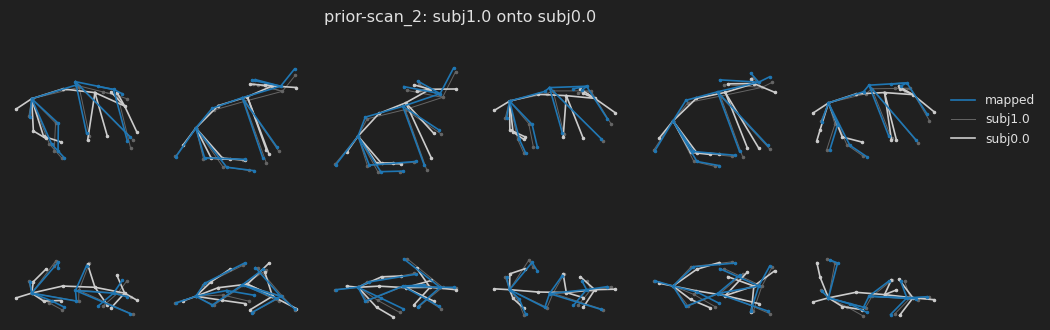

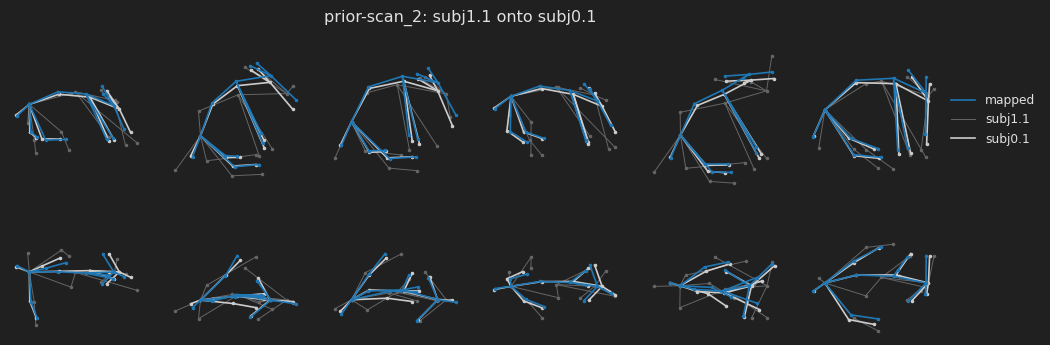

In [58]:
armature = Armature.from_config(cfg["dataset"])
n_mappings = len(mappings["ref"])

for model_name in scan_cfg["models"]:
    for i_map in range(n_mappings):
        gallery = galleries[i_map]
        ref_poses = ref[model_name][i_map]
        compare_poses = compare[model_name][i_map]
        ref_sess = mappings["ref"][i_map]
        mapped_poses = mapped[model_name][i_map]
        comp_session = mappings["compare"][i_map]

        fig, ax = plt.subplots(
            2,
            len(gallery),
            figsize=(len(gallery) * 2, 4),
        )
        for j, ix in enumerate(gallery):
            viz_util.plot_mouse_views(
                ax[:, j],
                mapped_poses[j],
                armature,
                color=colors.C[0],
                label="mapped",
                zorder = 3
            )
            viz_util.plot_mouse_views(
                ax[:, j],
                compare_poses[j],
                armature,
                color=colors.subtle,
                line_kw=dict(lw=0.7),
                label=comp_session,
                zorder=-3,
            )
            viz_util.plot_mouse_views(
                ax[:, j],
                ref_poses[j],
                armature,
                color=colors.neutral,
                label=ref_sess,
                zorder = 0
            )

        viz.util.legend(ax[0, -1])

        for a in ax.ravel():
            viz.util.axes_off(a)

        fig.suptitle(f"{model_name}: {mappings['compare'][i_map]} onto {mappings['ref'][i_map]}")
        plt.show()

In [59]:
model_name = "prior-scan_2"
scan_name = "prior-scan"
ckpt = methods.load_fit(project.model(model_name))
cfg = config.load_model_config(project.model_config(model_name))
model = instantiation.get_model(cfg)
param_hist = scans.merge_param_hist_with_hyperparams(
    model,
    ckpt["params"],
    ckpt["meta"]["param_hist"])
dataset, keypoint_dataset = scans.load_scan_dataset(project, scan_name)
pal = colors.cts1(int(param_hist.morph.n_dims[0]))
fig, ax = plt.subplots(dataset.n_bodies, 1, figsize=(7, 
4))
for i_body, body_name in dataset._body_names.items():
    upd_norms = jla.norm(param_hist.morph.mode_updates[:, i_body], axis = -2)
    for i_mode in range(param_hist.morph.n_dims[0]):
        ax[i_body].plot(upd_norms[:, i_mode], color = pal[i_mode], lw = 1, label = i_mode)
    ax[i_body].set_ylabel(body_name[-7:])
viz.util.legend(ax[0])
fig.suptitle(f"{model_name} pc updates")
plotter.finalize(fig, None)

AttributeError: module 'kpsn.viz.scans' has no attribute 'merge_param_hist_with_hyperparams'

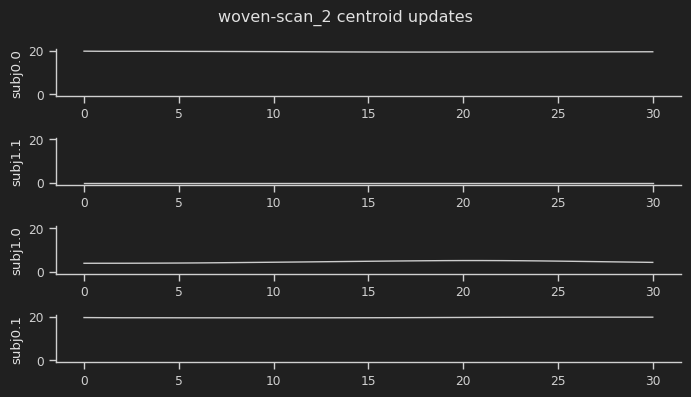

In [12]:
model_name = "woven-scan_2"
scan_name = "woven-scan"
ckpt = methods.load_fit(project.model(model_name))
cfg = config.load_model_config(project.model_config(model_name))
model = instantiation.get_model(cfg)
param_hist = scans.merge_param_hist_with_hyperparams(
    model,
    ckpt["params"],
    ckpt["meta"]["param_hist"])
dataset, keypoint_dataset = scans.load_scan_dataset(project, scan_name)
fig, ax = plt.subplots(dataset.n_bodies, 1, figsize=(7, 4), sharey = True)
for i_body, body_name in dataset._body_names.items():
    upd_norms = jla.norm(param_hist.morph.offset_updates[:, i_body], axis = -1)
    ax[i_body].plot(upd_norms, color = colors.neutral, lw = 1)
    ax[i_body].set_ylabel(body_name[-7:])
fig.suptitle(f"{model_name} centroid updates")
plotter.finalize(fig, None)

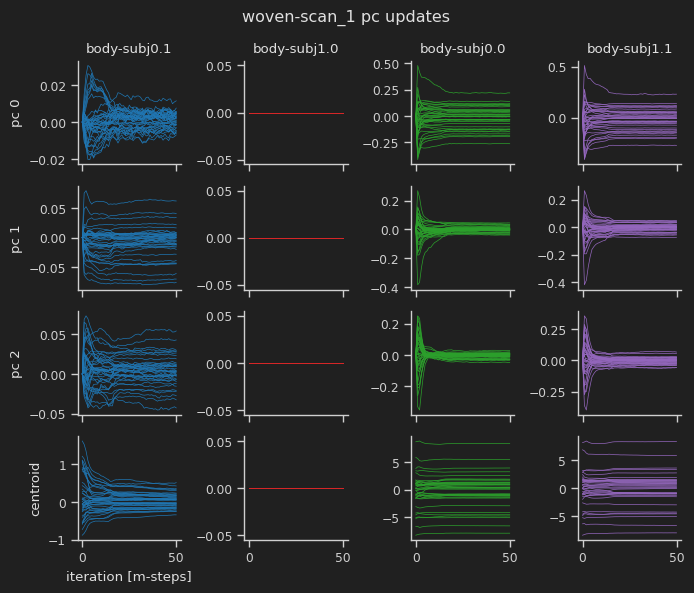

In [24]:
model_name = 'woven-scan_1'
ckpt = methods.load_fit(project.model(model_name))
cfg = config.load_model_config(project.model_config(model_name))
_dataset = loaders.load_dataset(cfg["dataset"])
_dataset = methods.modify_dataset(project.model(model_name), _dataset)
model = instantiation.get_model(cfg)
param_hist = scans.merge_param_hist_with_hyperparams(
    model,
    ckpt["params"],
    ckpt["meta"]["param_hist"])
n_bodies = int(param_hist.morph.n_bodies[0])
n_dims = int(param_hist.morph.n_dims[0])
pal = [colors.C[0], colors.C[2], colors.C[1], colors.C[3]]
fig, ax = plt.subplots(n_dims + 1, n_bodies, figsize=(7, 6), sharex = True)
for i_body in range(n_bodies):
    for i_mode in range(n_dims):
        upds = param_hist.morph.mode_updates[:, i_body, :, i_mode]
        ax[i_mode, i_body].plot(upds, color = pal[i_body], lw = 0.5, label = [i_body] + [None] * (upds.shape[-1] - 1))
        ax[0, i_body].set_title(_dataset._body_names[i_body])
        ax[i_mode, 0].set_ylabel(f"pc {i_mode}")
    upds = param_hist.morph.offset_updates[:, i_body, :]
    ax[-1, i_body].plot(upds, color = pal[i_body], lw = 0.5)
        
ax[-1, 0].set_xlabel("iteration [m-steps]")
ax[-1, 0].set_ylabel("centroid")
# viz.util.legend(ax[0, -1])
fig.suptitle(f"{model_name} pc updates")
plotter.finalize(fig, None)

### single model (replication of old code)

In [4]:
model_dir, cfg = create_model(project, 'lrakp_default-replicate', config_overrides = {
    'fit.learning_rate': 1,
    'fit.n_steps': 10,
    'morph.n_dims': 1,
    'pose.wish_var': None,
    'pose.wish_dof': None,
    'pose.n_components': 5,
})
fit_data = methods.fit(
    project.model('lrakp_default-replicate'),
    log_every = 1,)

INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 2395 frames
INFO:root:Adjusting learning rate:1 -> 0.00020876826722338206
INFO:root:Loading LR schedule: const
INFO:root:Step 0 : loss = 451664.25
INFO:root:Step 1 : loss = 353912.6875
INFO:root:Step 2 : loss = 337944.46875
INFO:root:Step 3 : loss = 331195.84375
INFO:root:Step 4 : loss = 326370.25
INFO:root:Step 5 : loss = 323850.0
INFO:root:Step 6 : loss = 322896.1875
INFO:root:Step 7 : loss = 322450.375
INFO:root:Step 8 : loss = 322168.28125
INFO:root:Step 9 : loss = 321968.28125


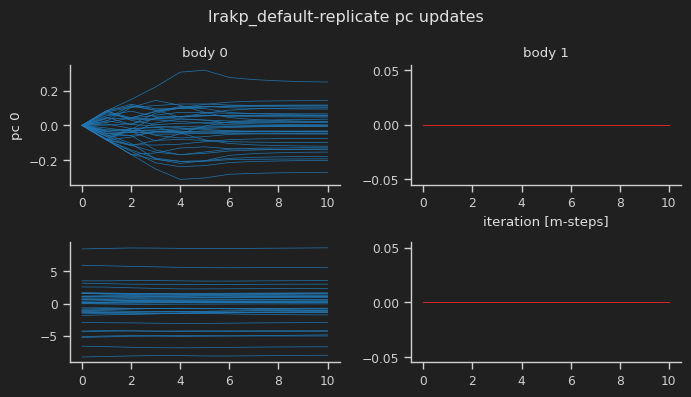

In [5]:
model_name = 'lrakp_default-replicate'
ckpt = methods.load_fit(project.model(model_name))
cfg = config.load_model_config(project.model_config(model_name))
model = instantiation.get_model(cfg)
param_hist = scans.merge_param_hist_with_hyperparams(
    model,
    ckpt["params"],
    ckpt["meta"]["param_hist"])
n_bodies = int(param_hist.morph.n_bodies[0])
n_dims = int(param_hist.morph.n_dims[0])
pal = [colors.C[0], colors.C[2]]
fig, ax = plt.subplots(n_dims + 1, n_bodies, figsize=(7, 4))
for i_body in range(n_bodies):
    for i_mode in range(n_dims):
        upds = param_hist.morph.mode_updates[:, i_body, :, i_mode]
        ax[i_mode, i_body].plot(upds, color = pal[i_body], lw = 0.5, label = [i_body] + [None] * (upds.shape[-1] - 1))
        ax[0, i_body].set_title(f"body {i_body}")
        ax[i_mode, 0].set_ylabel(f"pc {i_mode}")
    upds = param_hist.morph.offset_updates[:, i_body, :]
    ax[-1, i_body].plot(upds, color = pal[i_body], lw = 0.5)
        
ax[0, -1].set_xlabel("iteration [m-steps]")
# viz.util.legend(ax[0, -1])
fig.suptitle(f"{model_name} pc updates")
plotter.finalize(fig, None)

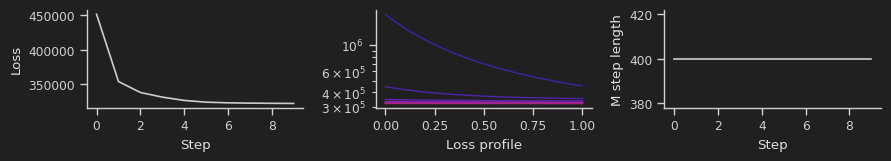

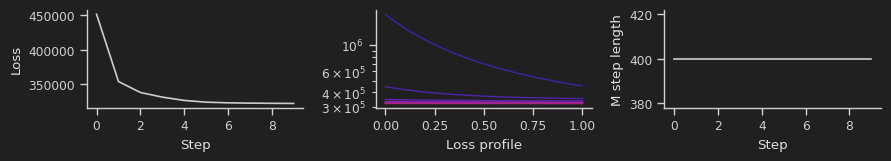

In [6]:
checkpoint = methods.load_fit(project.model('lrakp_default-replicate'))

def em_loss(loss_hist, mstep_losses, mstep_relative = True):
    fig, ax = plt.subplots(figsize = (9, 1.7), ncols = 3)
    
    pal = sns.hls_palette(len(mstep_losses) * 5, h = 0.7, l = 0.4)[:len(mstep_losses)]

    mstep_lengths = []
    for i in range(0, len(mstep_losses)):
        
        if np.any(~np.isfinite(mstep_losses[i])):
            curr_loss = mstep_losses[i][:np.argmax(~np.isfinite(mstep_losses[i]))]
            if len(curr_loss) == 0: continue
        else:
            curr_loss = mstep_losses[i]
        mstep_lengths.append(len(curr_loss))
        
        if mstep_relative:
            plot_y = (curr_loss - curr_loss.min()) / (curr_loss.max() - curr_loss.min())
        else: plot_y = curr_loss

        ax[1].plot(
            np.linspace(0, 1, len(curr_loss)),
            plot_y,
            color = pal[i], lw = 1)
        
    if not mstep_relative:
        ax[1].set_yscale('log')
        
    ax[0].plot(loss_hist, colors.neutral)
    if loss_hist.max() > 2 * loss_hist[0]:
        ax[0].set_ylim(None, 2 * loss_hist[0])
    ax[2].plot(np.arange(len(mstep_lengths)), mstep_lengths, colors.neutral)

    ax[1].set_xlabel("Loss profile")
    ax[2].set_ylabel("M step length")
    ax[2].set_xlabel("Step")
    ax[0].set_ylabel("Loss")
    ax[0].set_xlabel("Step")
    
    fig.tight_layout()
    sns.despine()
    return fig

em_loss(checkpoint['meta']['loss'], checkpoint['meta']['mstep_losses'], mstep_relative=False)

In [7]:
# map `compare` session on to `ref` session, where the two have exact
# frame correspondence
mappings = {"ref": ["subj0"], "compare": ["subj1"]}

model_name = 'lrakp_default-replicate'
ref = defaultdict(list); mapped = defaultdict(list); compare = defaultdict(list)

cfg = config.load_model_config(project.model_config(model_name))
armature = Armature.from_config(cfg["dataset"])
model = instantiation.get_model(cfg)
checkpoint = methods.load_fit(project.model(model_name))


# load split and non-split versions of the dataset
dataset = loaders.raw_npy.load(cfg["dataset"])
dataset_aligned, align_inverse = alignment.align(
    dataset, cfg["alignment"]
)
dataset_reduced, reduction_inverse = features.reduce_to_features(
    dataset_aligned, cfg["features"]
)
# in case this was a split fit
dataset_train = methods.modify_dataset(
    project.model(model_name), dataset_reduced
)
_inflate = lambda x: features.inflate(
    x, cfg["features"], reduction_inverse
)
inflated_train = _inflate(dataset_train)


n_mappings = len(mappings["ref"])
galleries = [
    jnp.stack(list(viz.util.select_frame_gallery(
        inflated_train.get_session(ref_sess), armature, return_ixs=True
    ).values()))
    for ref_sess in mappings["ref"]
]

for i_map in range(n_mappings):
    ref_sess = mappings["ref"][i_map]
    compare_sess = mappings["compare"][i_map]
    pose_ixs = galleries[i_map]
    ref_body = dataset_train.sess_bodies[ref_sess]
    compare_body = dataset_train.sess_bodies[compare_sess]

    # map from compare_sess onto the body of ref_sess and grab pose_ixs
    mapped_reduced = model_util.apply_bodies(
        model.morph,
        checkpoint["params"].morph,
        dataset_train.session_subset([compare_sess], bad_ref_ok=True),
        {compare_sess: ref_body},
    ).get_session(compare_sess)[pose_ixs]
    mapped[model_name].append(_inflate(mapped_reduced))
    ref[model_name].append(inflated_train.get_session(ref_sess)[pose_ixs])
    compare[model_name].append(inflated_train.get_session(compare_sess)[pose_ixs])

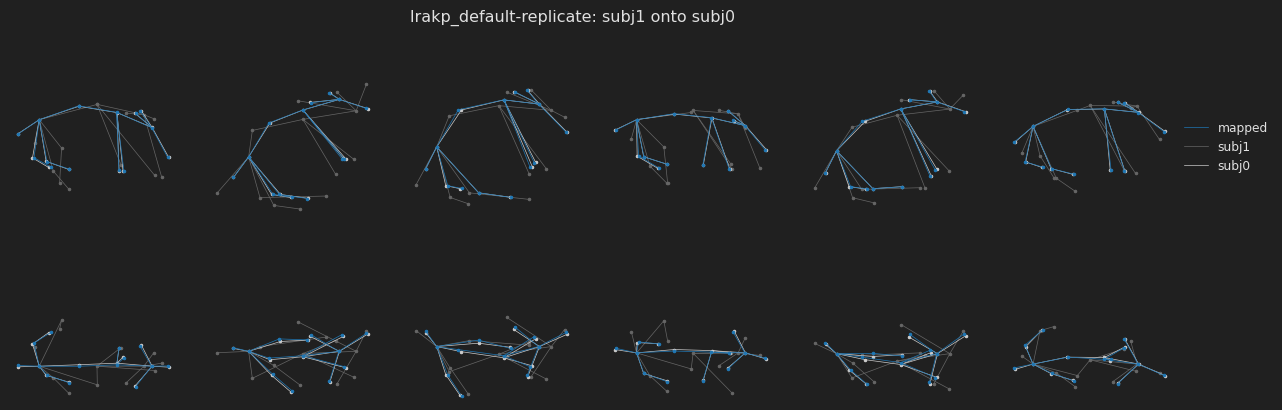

In [8]:
armature = Armature.from_config(cfg["dataset"])
n_mappings = len(mappings["ref"])

for i_map in range(n_mappings):
    gallery = galleries[i_map]
    ref_poses = ref[model_name][i_map]
    compare_poses = compare[model_name][i_map]
    ref_sess = mappings["ref"][i_map]
    mapped_poses = mapped[model_name][i_map]
    comp_session = mappings["compare"][i_map]

    fig, ax = plt.subplots(
        2,
        len(gallery),
        figsize=(len(gallery) * 2.5, 5),
    )
    for j, ix in enumerate(gallery):
        viz_util.plot_mouse_views(
            ax[:, j],
            mapped_poses[j],
            armature,
            color=colors.C[0],
            label="mapped",
            line_kw=dict(lw=0.5),
            zorder = 3
        )
        viz_util.plot_mouse_views(
            ax[:, j],
            compare_poses[j],
            armature,
            color=colors.subtle,
            line_kw=dict(lw=0.5),
            label=comp_session,
            zorder=-3,
        )
        viz_util.plot_mouse_views(
            ax[:, j],
            ref_poses[j],
            armature,
            color=colors.neutral,
            label=ref_sess,
            line_kw=dict(lw=0.5),
            zorder = 0
        )

    viz.util.legend(ax[0, -1])

    for a in ax.ravel():
        viz.util.axes_off(a)

    fig.suptitle(f"{model_name}: {mappings['compare'][i_map]} onto {mappings['ref'][i_map]}")
    plt.show()

### single split model

In [67]:
model_dir, cfg = create_model(project, 'split-replicate-lr8',
    config = config.load_model_config(project.model_config('split-replicate')),
    config_overrides = {
    'fit.em.learning_rate': 8,
    'fit.em.n_steps': 50,
})

In [68]:
fit_data = methods.fit(
    project.model('split-replicate-lr8'),
    log_every = 1,)

INFO:root:Continuing from checkpoint at step 29.
INFO:root:Adjusting learning rate:8 -> 0.0016701461377870565
INFO:root:Loading LR schedule: const
INFO:root:Step 30 : loss = 318095.0
INFO:root:Step 31 : loss = 318080.65625
INFO:root:Step 32 : loss = 318067.625
INFO:root:Step 33 : loss = 318061.0
INFO:root:Step 34 : loss = 318052.28125
INFO:root:Step 35 : loss = 318042.34375
INFO:root:Step 36 : loss = 318028.1875
INFO:root:Step 37 : loss = 318023.1875
INFO:root:Step 38 : loss = 318022.53125
INFO:root:Step 39 : loss = 318017.90625
INFO:root:Step 40 : loss = 318012.5625
INFO:root:Step 41 : loss = 318011.71875
INFO:root:Step 42 : loss = 318008.84375
INFO:root:Step 43 : loss = 318005.40625
INFO:root:Step 44 : loss = 318007.46875
INFO:root:Step 45 : loss = 318001.15625
INFO:root:Step 46 : loss = 317994.15625
INFO:root:Step 47 : loss = 317984.15625
INFO:root:Step 48 : loss = 317975.34375
INFO:root:Step 49 : loss = 317973.0625


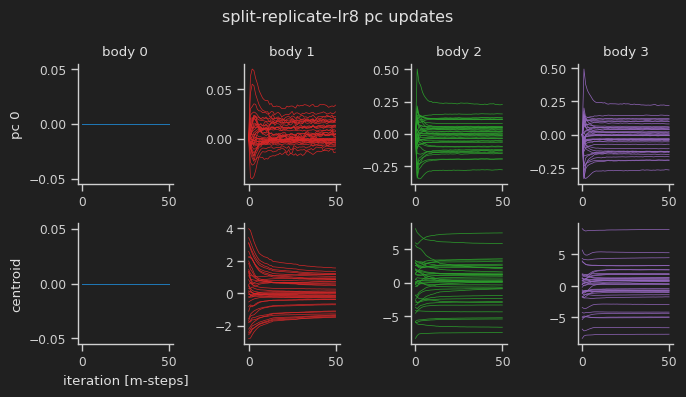

In [69]:
model_name = 'split-replicate-lr8'
ckpt = methods.load_fit(project.model(model_name))
cfg = config.load_model_config(project.model_config(model_name))
_dataset = loaders.load_dataset(cfg["dataset"])
_dataset = methods.modify_dataset(project.model(model_name), _dataset)
model = instantiation.get_model(cfg)
param_hist = scans.merge_param_hist_with_hyperparams(
    model,
    ckpt["params"],
    ckpt["meta"]["param_hist"])
n_bodies = int(param_hist.morph.n_bodies[0])
n_dims = int(param_hist.morph.n_dims[0])
pal = [colors.C[0], colors.C[2], colors.C[1], colors.C[3]]
fig, ax = plt.subplots(n_dims + 1, n_bodies, figsize=(7, 4))
for i_body in range(n_bodies):
    for i_mode in range(n_dims):
        upds = param_hist.morph.mode_updates[:, i_body, :, i_mode]
        ax[i_mode, i_body].plot(upds, color = pal[i_body], lw = 0.5, label = [i_body] + [None] * (upds.shape[-1] - 1))
        ax[0, i_body].set_title(f"body {i_body}")
        ax[i_mode, 0].set_ylabel(f"pc {i_mode}")
    upds = param_hist.morph.offset_updates[:, i_body, :]
    ax[-1, i_body].plot(upds, color = pal[i_body], lw = 0.5)
        
ax[-1, 0].set_xlabel("iteration [m-steps]")
ax[-1, 0].set_ylabel("centroid")
# viz.util.legend(ax[0, -1])
fig.suptitle(f"{model_name} pc updates")
plotter.finalize(fig, None)

split-replicate-lr8


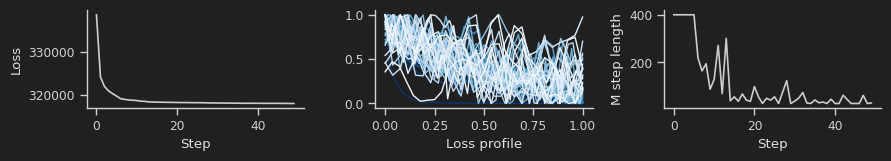

In [70]:
model_name = 'split-replicate-lr8'
checkpoint = methods.load_fit(project.model(model_name))
fig = viz.model.em_loss(checkpoint, mstep_relative=True)
print(model_name)
plotter.finalize(fig, None)


In [71]:
# map `compare` session on to `ref` session, where the two have exact
# frame correspondence
mappings = {"ref": ["subj0.0", "subj0.1"], "compare": ["subj1.0", "subj1.1"]}

model_name = 'split-replicate-lr8'
ref = defaultdict(list); mapped = defaultdict(list); compare = defaultdict(list)

cfg = config.load_model_config(project.model_config(model_name))
armature = Armature.from_config(cfg["dataset"])
model = instantiation.get_model(cfg)
checkpoint = methods.load_fit(project.model(model_name))


# load split and non-split versions of the dataset
dataset = loaders.raw_npy.load(cfg["dataset"])
dataset_aligned, align_inverse = alignment.align(
    dataset, cfg["alignment"]
)
dataset_reduced, reduction_inverse = features.reduce_to_features(
    dataset_aligned, cfg["features"]
)
# in case this was a split fit
dataset_train = methods.modify_dataset(
    project.model(model_name), dataset_reduced
)
_inflate = lambda x: features.inflate(
    x, cfg["features"], reduction_inverse
)
inflated_train = _inflate(dataset_train)


n_mappings = len(mappings["ref"])
galleries = [
    jnp.stack(list(viz.util.select_frame_gallery(
        inflated_train.get_session(ref_sess), armature, return_ixs=True
    ).values()))
    for ref_sess in mappings["ref"]
]

for i_map in range(n_mappings):
    ref_sess = mappings["ref"][i_map]
    compare_sess = mappings["compare"][i_map]
    pose_ixs = galleries[i_map]
    ref_body = dataset_train.sess_bodies[ref_sess]
    compare_body = dataset_train.sess_bodies[compare_sess]

    # map from compare_sess onto the body of ref_sess and grab pose_ixs
    mapped_reduced = model_util.apply_bodies(
        model.morph,
        checkpoint["params"].morph,
        dataset_train.session_subset([compare_sess], bad_ref_ok=True),
        {compare_sess: ref_body},
    ).get_session(compare_sess)[pose_ixs]
    mapped[model_name].append(_inflate(mapped_reduced))
    ref[model_name].append(inflated_train.get_session(ref_sess)[pose_ixs])
    compare[model_name].append(inflated_train.get_session(compare_sess)[pose_ixs])

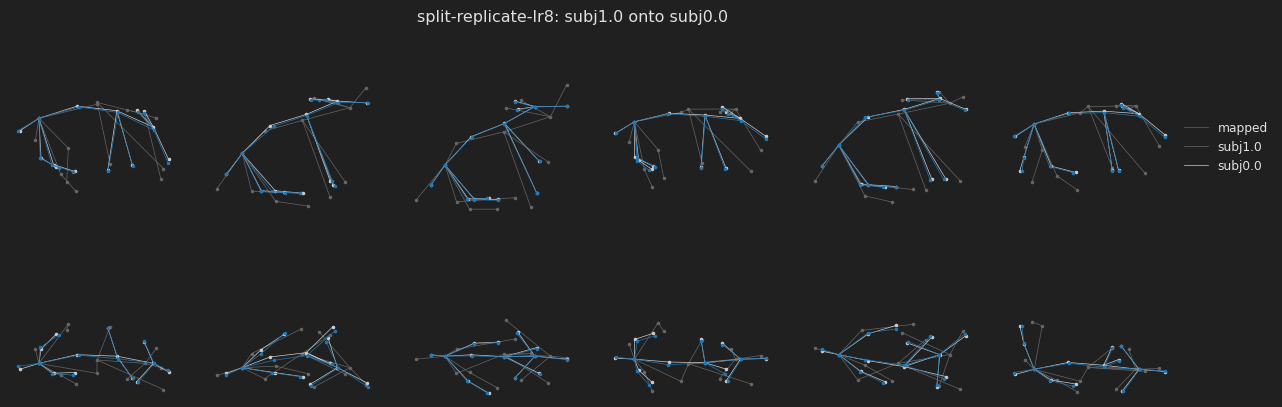

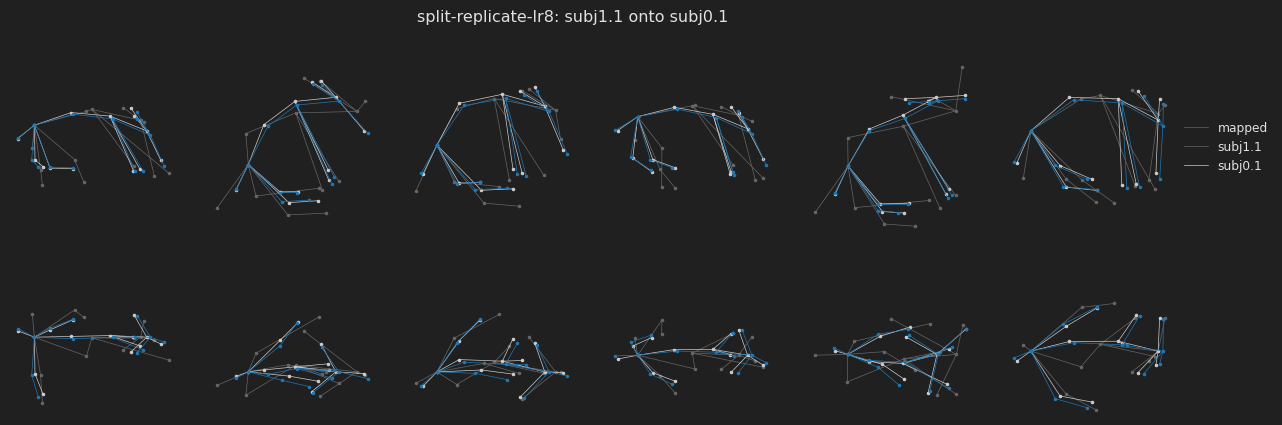

In [72]:
armature = Armature.from_config(cfg["dataset"])
n_mappings = len(mappings["ref"])

for i_map in range(n_mappings):
    gallery = galleries[i_map]
    ref_poses = ref[model_name][i_map]
    compare_poses = compare[model_name][i_map]
    ref_sess = mappings["ref"][i_map]
    mapped_poses = mapped[model_name][i_map]
    comp_session = mappings["compare"][i_map]

    fig, ax = plt.subplots(
        2,
        len(gallery),
        figsize=(len(gallery) * 2.5, 5),
    )
    for j, ix in enumerate(gallery):
        viz_util.plot_mouse_views(
            ax[:, j],
            mapped_poses[j],
            armature,
            color=colors.C[0],
            label="mapped",
            line_kw=dict(lw=0.5),
            zorder = 3
        )
        viz_util.plot_mouse_views(
            ax[:, j],
            compare_poses[j],
            armature,
            color=colors.subtle,
            line_kw=dict(lw=0.5),
            label=comp_session,
            zorder=-3,
        )
        viz_util.plot_mouse_views(
            ax[:, j],
            ref_poses[j],
            armature,
            color=colors.neutral,
            label=ref_sess,
            line_kw=dict(lw=0.5),
            zorder = 0
        )

    viz.util.legend(ax[0, -1])

    for a in ax.ravel():
        viz.util.axes_off(a)

    fig.suptitle(f"{model_name}: {mappings['compare'][i_map]} onto {mappings['ref'][i_map]}")
    plt.show()

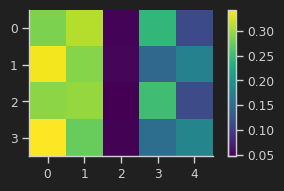

bidict({0: 'subj0.0', 1: 'subj0.1', 2: 'subj1.0', 3: 'subj1.1'})


In [66]:
model_name = 'split-replicate-lr8'
ckpt = methods.load_fit(project.model(model_name))
cfg = config.load_model_config(project.model_config(model_name))
_dataset = loaders.load_dataset(cfg["dataset"])
_dataset = methods.modify_dataset(project.model(model_name), _dataset)
fig, ax = plt.subplots(figsize = (3.5, 2))
plt.imshow(ckpt["params"].pose.subj_weights)
plt.colorbar()
plotter.finalize(fig, None)
print(_dataset._session_names)

### with n_components = 1

In [31]:
model_dir, cfg = create_model(project, 'split-replicate-poseL1-lr8',
    config = config.load_model_config(project.model_config('split-replicate')),
    config_overrides = {
    'pose.n_components': 1,
    'fit.em.learning_rate': 8,
})

fit_data = methods.fit(
    project.model('split-replicate-poseL1-lr8'),
    log_every = 1,)

INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 1198 frames


session lengths: {'subj0.0': 1198, 'subj0.1': 1197, 'subj1.0': 1198, 'subj1.1': 1197}


INFO:root:Adjusting learning rate:8 -> 0.0016701461377870565
INFO:root:Loading LR schedule: const
INFO:root:Step 0 : loss = 355062.125
INFO:root:Step 1 : loss = 354824.28125
INFO:root:Step 2 : loss = 354815.15625
INFO:root:Step 3 : loss = 354808.625
INFO:root:Step 4 : loss = 354801.46875
INFO:root:Step 5 : loss = 354797.875
INFO:root:Step 6 : loss = 354794.0625
INFO:root:Step 7 : loss = 354795.34375
INFO:root:Step 8 : loss = 354793.5625
INFO:root:Step 9 : loss = 354791.15625


split-replicate-poseL1-lr8


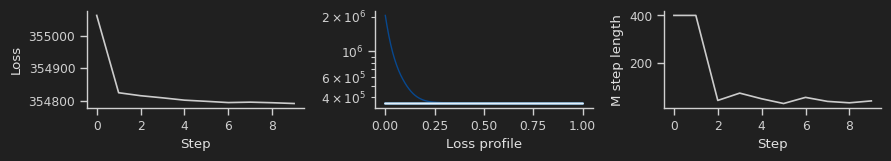

In [32]:
model_name = 'split-replicate-poseL1-lr8'
checkpoint = methods.load_fit(project.model(model_name))
fig = viz.model.em_loss(checkpoint, mstep_relative=False)
print(model_name)
plotter.finalize(fig, None)

session lengths: {'subj0.0': 1198, 'subj0.1': 1197, 'subj1.0': 1198, 'subj1.1': 1197}


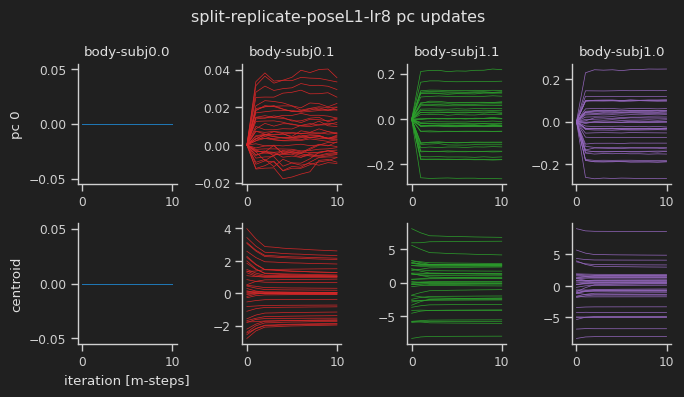

In [33]:
model_name = 'split-replicate-poseL1-lr8'
ckpt = methods.load_fit(project.model(model_name))
cfg = config.load_model_config(project.model_config(model_name))
_dataset = loaders.load_dataset(cfg["dataset"])
_dataset = methods.modify_dataset(project.model(model_name), _dataset)
model = instantiation.get_model(cfg)
param_hist = scans.merge_param_hist_with_hyperparams(
    model,
    ckpt["params"],
    ckpt["meta"]["param_hist"])
n_bodies = int(param_hist.morph.n_bodies[0])
n_dims = int(param_hist.morph.n_dims[0])
pal = [colors.C[0], colors.C[2], colors.C[1], colors.C[3]]
fig, ax = plt.subplots(n_dims + 1, n_bodies, figsize=(7, 4))
for i_body in range(n_bodies):
    for i_mode in range(n_dims):
        upds = param_hist.morph.mode_updates[:, i_body, :, i_mode]
        ax[i_mode, i_body].plot(upds, color = pal[i_body], lw = 0.5, label = [i_body] + [None] * (upds.shape[-1] - 1))
        ax[0, i_body].set_title(_dataset._body_names[i_body])
        ax[i_mode, 0].set_ylabel(f"pc {i_mode}")
    upds = param_hist.morph.offset_updates[:, i_body, :]
    ax[-1, i_body].plot(upds, color = pal[i_body], lw = 0.5)
        
ax[-1, 0].set_xlabel("iteration [m-steps]")
ax[-1, 0].set_ylabel("centroid")
# viz.util.legend(ax[0, -1])
fig.suptitle(f"{model_name} pc updates")
plotter.finalize(fig, None)

In [34]:
# map `compare` session on to `ref` session, where the two have exact
# frame correspondence
mappings = {"ref": ["subj0.0", "subj0.1"], "compare": ["subj1.0", "subj1.1"]}

model_name = 'split-replicate-poseL1'
ref = defaultdict(list); mapped = defaultdict(list); compare = defaultdict(list)

cfg = config.load_model_config(project.model_config(model_name))
armature = Armature.from_config(cfg["dataset"])
model = instantiation.get_model(cfg)
checkpoint = methods.load_fit(project.model(model_name))


# load split and non-split versions of the dataset
dataset = loaders.raw_npy.load(cfg["dataset"])
dataset_aligned, align_inverse = alignment.align(
    dataset, cfg["alignment"]
)
dataset_reduced, reduction_inverse = features.reduce_to_features(
    dataset_aligned, cfg["features"]
)
# in case this was a split fit
dataset_train = methods.modify_dataset(
    project.model(model_name), dataset_reduced
)
_inflate = lambda x: features.inflate(
    x, cfg["features"], reduction_inverse
)
inflated_train = _inflate(dataset_train)


n_mappings = len(mappings["ref"])
galleries = [
    jnp.stack(list(viz.util.select_frame_gallery(
        inflated_train.get_session(ref_sess), armature, return_ixs=True
    ).values()))
    for ref_sess in mappings["ref"]
]

for i_map in range(n_mappings):
    ref_sess = mappings["ref"][i_map]
    compare_sess = mappings["compare"][i_map]
    pose_ixs = galleries[i_map]
    ref_body = dataset_train.sess_bodies[ref_sess]
    compare_body = dataset_train.sess_bodies[compare_sess]

    # map from compare_sess onto the body of ref_sess and grab pose_ixs
    mapped_reduced = model_util.apply_bodies(
        model.morph,
        checkpoint["params"].morph,
        dataset_train.session_subset([compare_sess], bad_ref_ok=True),
        {compare_sess: ref_body},
    ).get_session(compare_sess)[pose_ixs]
    mapped[model_name].append(_inflate(mapped_reduced))
    ref[model_name].append(inflated_train.get_session(ref_sess)[pose_ixs])
    compare[model_name].append(inflated_train.get_session(compare_sess)[pose_ixs])

session lengths: {'subj0.0': 1198, 'subj0.1': 1197, 'subj1.0': 1198, 'subj1.1': 1197}


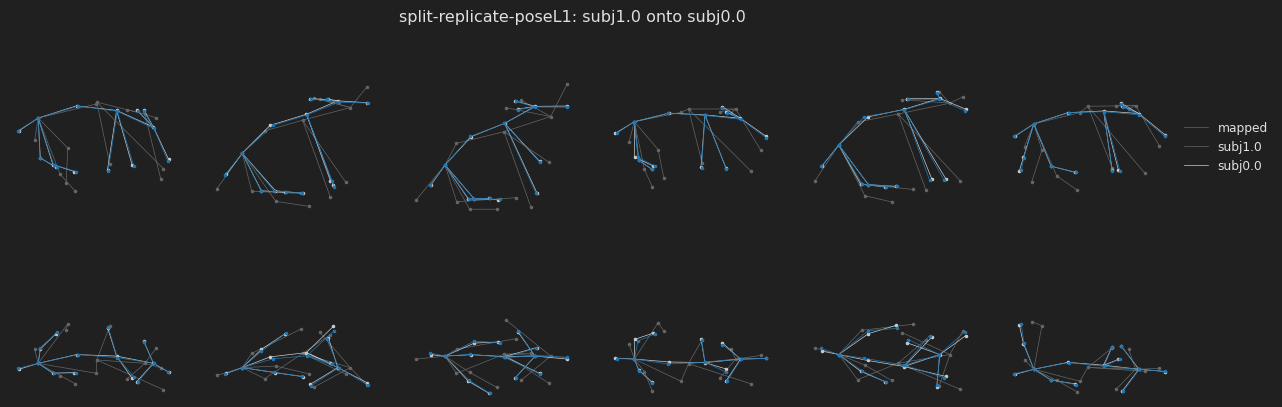

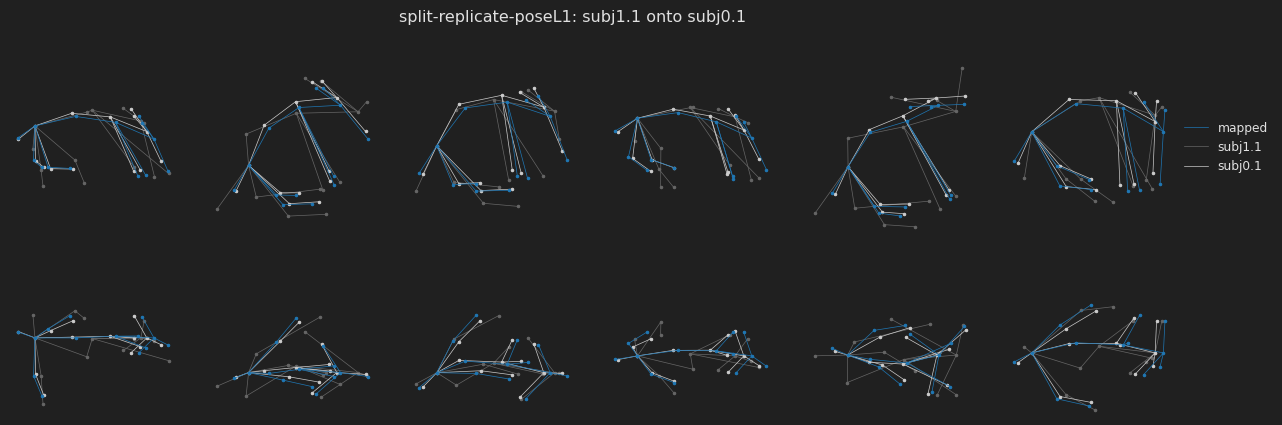

In [35]:
armature = Armature.from_config(cfg["dataset"])
n_mappings = len(mappings["ref"])

for i_map in range(n_mappings):
    gallery = galleries[i_map]
    ref_poses = ref[model_name][i_map]
    compare_poses = compare[model_name][i_map]
    ref_sess = mappings["ref"][i_map]
    mapped_poses = mapped[model_name][i_map]
    comp_session = mappings["compare"][i_map]

    fig, ax = plt.subplots(
        2,
        len(gallery),
        figsize=(len(gallery) * 2.5, 5),
    )
    for j, ix in enumerate(gallery):
        viz_util.plot_mouse_views(
            ax[:, j],
            mapped_poses[j],
            armature,
            color=colors.C[0],
            label="mapped",
            line_kw=dict(lw=0.5),
            zorder = 3
        )
        viz_util.plot_mouse_views(
            ax[:, j],
            compare_poses[j],
            armature,
            color=colors.subtle,
            line_kw=dict(lw=0.5),
            label=comp_session,
            zorder=-3,
        )
        viz_util.plot_mouse_views(
            ax[:, j],
            ref_poses[j],
            armature,
            color=colors.neutral,
            label=ref_sess,
            line_kw=dict(lw=0.5),
            zorder = 0
        )

    viz.util.legend(ax[0, -1])

    for a in ax.ravel():
        viz.util.axes_off(a)

    fig.suptitle(f"{model_name}: {mappings['compare'][i_map]} onto {mappings['ref'][i_map]}")
    plt.show()

### interleaved

In [47]:
model_dir, cfg = create_model(project, 'split-replicate-interleaved-lr8',
    config = config.load_model_config(project.model_config('split-replicate')),
    config_overrides = {
    'fit.em.learning_rate': 8,
    'fit.split_type': 'interleaved',
    'fit.em.n_steps': 30,
})
fit_data = methods.fit(
    project.model('split-replicate-interleaved-lr8'),
    log_every = 1,)

INFO:root:Continuing from checkpoint at step 9.
INFO:root:Adjusting learning rate:8 -> 0.0016701461377870565
INFO:root:Loading LR schedule: const


session lengths: {'subj0.0': 1200, 'subj0.1': 1195, 'subj1.0': 1200, 'subj1.1': 1195}


INFO:root:Step 10 : loss = 319254.78125
INFO:root:Step 11 : loss = 319108.75
INFO:root:Step 12 : loss = 318958.6875
INFO:root:Step 13 : loss = 318825.65625
INFO:root:Step 14 : loss = 318708.78125
INFO:root:Step 15 : loss = 318649.0625
INFO:root:Step 16 : loss = 318591.84375
INFO:root:Step 17 : loss = 318539.5625
INFO:root:Step 18 : loss = 318496.53125
INFO:root:Step 19 : loss = 318467.875
INFO:root:Step 20 : loss = 318417.5625
INFO:root:Step 21 : loss = 318385.15625
INFO:root:Step 22 : loss = 318361.71875
INFO:root:Step 23 : loss = 318346.0
INFO:root:Step 24 : loss = 318323.4375
INFO:root:Step 25 : loss = 318300.59375
INFO:root:Step 26 : loss = 318281.3125
INFO:root:Step 27 : loss = 318263.78125
INFO:root:Step 28 : loss = 318246.46875
INFO:root:Step 29 : loss = 318228.625


Reloading 'kpsn.io.utils'.
Reloading 'kpsn.viz.model'.
>>> loss: split-replicate-interleaved-lr8


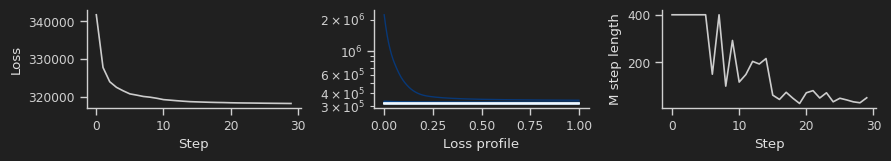

In [48]:
model_name = 'split-replicate-interleaved-lr8'
checkpoint = methods.load_fit(project.model(model_name))
fig = viz.model.em_loss(checkpoint, mstep_relative=False)
print(">>> loss:",  model_name)
plotter.finalize(fig, None)


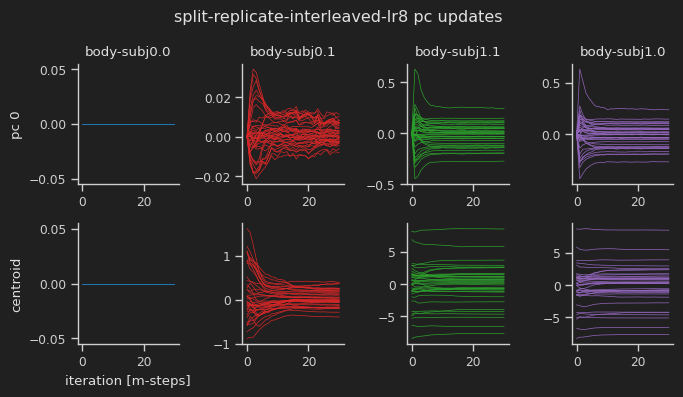

In [52]:
model_name = 'split-replicate-interleaved-lr8'
ckpt = methods.load_fit(project.model(model_name))
cfg = config.load_model_config(project.model_config(model_name))
_dataset = loaders.load_dataset(cfg["dataset"])
_dataset = methods.modify_dataset(project.model(model_name), _dataset)
model = instantiation.get_model(cfg)
param_hist = scans.merge_param_hist_with_hyperparams(
    model,
    ckpt["params"],
    ckpt["meta"]["param_hist"])
n_bodies = int(param_hist.morph.n_bodies[0])
n_dims = int(param_hist.morph.n_dims[0])
pal = [colors.C[0], colors.C[2], colors.C[1], colors.C[3]]
fig, ax = plt.subplots(n_dims + 1, n_bodies, figsize=(7, 4))
for i_body in range(n_bodies):
    for i_mode in range(n_dims):
        upds = param_hist.morph.mode_updates[:, i_body, :, i_mode]
        ax[i_mode, i_body].plot(upds, color = pal[i_body], lw = 0.5, label = [i_body] + [None] * (upds.shape[-1] - 1))
        ax[0, i_body].set_title(_dataset._body_names[i_body])
        ax[i_mode, 0].set_ylabel(f"pc {i_mode}")
    upds = param_hist.morph.offset_updates[:, i_body, :]
    ax[-1, i_body].plot(upds, color = pal[i_body], lw = 0.5)
        
ax[-1, 0].set_xlabel("iteration [m-steps]")
ax[-1, 0].set_ylabel("centroid")
# viz.util.legend(ax[0, -1])
fig.suptitle(f"{model_name} pc updates")
plotter.finalize(fig, None)

In [53]:
# map `compare` session on to `ref` session, where the two have exact
# frame correspondence
mappings = {"ref": ["subj0.0", "subj0.1"], "compare": ["subj1.0", "subj1.1"]}

model_name = 'split-replicate-interleaved-lr8'
ref = defaultdict(list); mapped = defaultdict(list); compare = defaultdict(list)

cfg = config.load_model_config(project.model_config(model_name))
armature = Armature.from_config(cfg["dataset"])
model = instantiation.get_model(cfg)
checkpoint = methods.load_fit(project.model(model_name))


# load split and non-split versions of the dataset
dataset = loaders.raw_npy.load(cfg["dataset"])
dataset_aligned, align_inverse = alignment.align(
    dataset, cfg["alignment"]
)
dataset_reduced, reduction_inverse = features.reduce_to_features(
    dataset_aligned, cfg["features"]
)
# in case this was a split fit
dataset_train = methods.modify_dataset(
    project.model(model_name), dataset_reduced
)
_inflate = lambda x: features.inflate(
    x, cfg["features"], reduction_inverse
)
inflated_train = _inflate(dataset_train)


n_mappings = len(mappings["ref"])
galleries = [
    jnp.stack(list(viz.util.select_frame_gallery(
        inflated_train.get_session(ref_sess), armature, return_ixs=True
    ).values()))
    for ref_sess in mappings["ref"]
]

for i_map in range(n_mappings):
    ref_sess = mappings["ref"][i_map]
    compare_sess = mappings["compare"][i_map]
    pose_ixs = galleries[i_map]
    ref_body = dataset_train.sess_bodies[ref_sess]
    compare_body = dataset_train.sess_bodies[compare_sess]

    # map from compare_sess onto the body of ref_sess and grab pose_ixs
    mapped_reduced = model_util.apply_bodies(
        model.morph,
        checkpoint["params"].morph,
        dataset_train.session_subset([compare_sess], bad_ref_ok=True),
        {compare_sess: ref_body},
    ).get_session(compare_sess)[pose_ixs]
    mapped[model_name].append(_inflate(mapped_reduced))
    ref[model_name].append(inflated_train.get_session(ref_sess)[pose_ixs])
    compare[model_name].append(inflated_train.get_session(compare_sess)[pose_ixs])

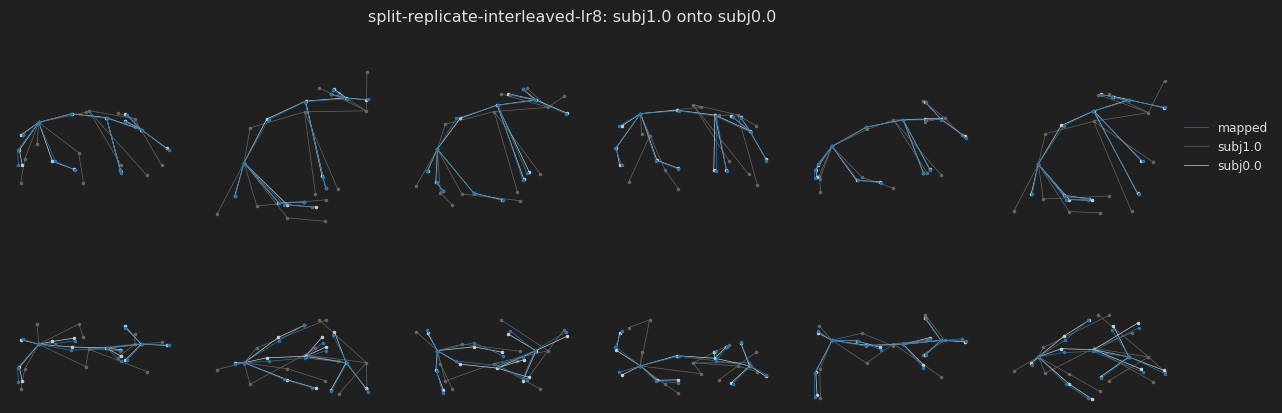

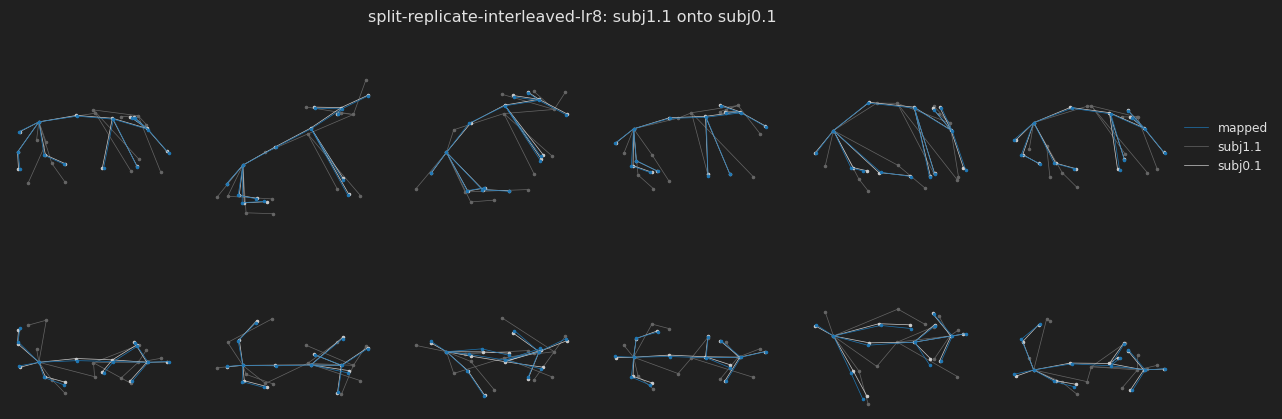

In [54]:
armature = Armature.from_config(cfg["dataset"])
n_mappings = len(mappings["ref"])

for i_map in range(n_mappings):
    gallery = galleries[i_map]
    ref_poses = ref[model_name][i_map]
    compare_poses = compare[model_name][i_map]
    ref_sess = mappings["ref"][i_map]
    mapped_poses = mapped[model_name][i_map]
    comp_session = mappings["compare"][i_map]

    fig, ax = plt.subplots(
        2,
        len(gallery),
        figsize=(len(gallery) * 2.5, 5),
    )
    for j, ix in enumerate(gallery):
        viz_util.plot_mouse_views(
            ax[:, j],
            mapped_poses[j],
            armature,
            color=colors.C[0],
            label="mapped",
            line_kw=dict(lw=0.5),
            zorder = 3
        )
        viz_util.plot_mouse_views(
            ax[:, j],
            compare_poses[j],
            armature,
            color=colors.subtle,
            line_kw=dict(lw=0.5),
            label=comp_session,
            zorder=-3,
        )
        viz_util.plot_mouse_views(
            ax[:, j],
            ref_poses[j],
            armature,
            color=colors.neutral,
            label=ref_sess,
            line_kw=dict(lw=0.5),
            zorder = 0
        )

    viz.util.legend(ax[0, -1])

    for a in ax.ravel():
        viz.util.axes_off(a)

    fig.suptitle(f"{model_name}: {mappings['compare'][i_map]} onto {mappings['ref'][i_map]}")
    plt.show()